# Objectives

Our aim is to predict 8 target categories:

1. Albacore tuna (ALB)
2. Bigeye tuna (BET)
3. Dolphin fish/Mahi Mahi (DOL)
4. Opah/Moon fish (LAG)
5. Sharks (SHARK)
6. Yellowfin tuna (YLT)
7. Other (meaning that there are fish present but not in the above categories) (OTHER)
8. No Fish (meaning that no fish is in the picture) (NoF)

In [1]:
%pwd

'/Users/hoangnguyen/Documents/study/kaggle/fish'

In [2]:
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/'

In [4]:
#import library
sys.path.insert(1, LESSON_HOME_DIR + '/utils/')
from imp import reload # In Python 2.x, this was a builtin, but in 3.x, it's in the imp module
import utils; reload(utils)
from utils import *

In [5]:
#import modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.misc import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Overview

## Train data

In [6]:
from subprocess import check_output
print(check_output(["ls", DATA_HOME_DIR + "/train/"]).decode("utf8"))

ALB
BET
DOL
LAG
NoF
OTHER
SHARK
YFT



Number of files for the species ALB : 1719
Number of files for the species BET : 200
Number of files for the species DOL : 117
Number of files for the species LAG : 67
Number of files for the species NoF : 465
Number of files for the species OTHER : 299
Number of files for the species SHARK : 176
Number of files for the species YFT : 734


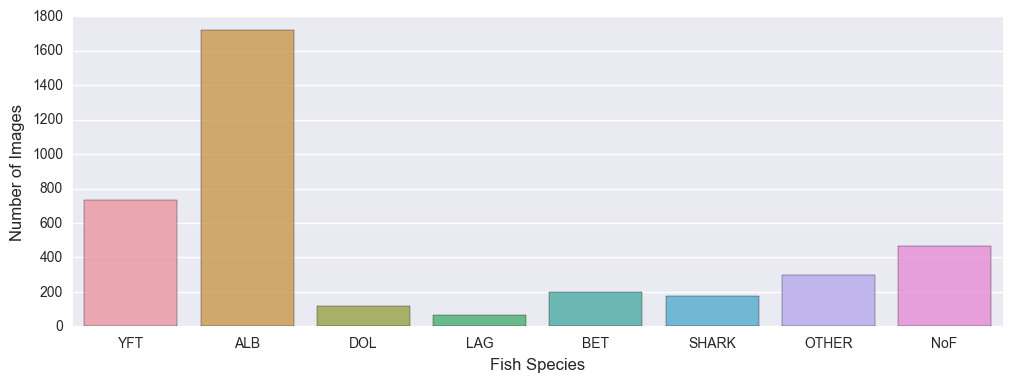

In [6]:
sub_folders = check_output(["ls", DATA_HOME_DIR + "/train/"]).decode("utf8").strip().split('\n')
fish_count_dict = {}

for sub_folder in sub_folders:
    file_name = check_output(["ls", DATA_HOME_DIR + "/train/" + sub_folder]).decode("utf8").strip().split('\n')
    num_of_files = len(file_name)
    print("Number of files for the species",sub_folder,":",num_of_files)
    fish_count_dict[sub_folder] = num_of_files
    
plt.figure(figsize=(12,4))
sns.barplot(list(fish_count_dict.keys()), list(fish_count_dict.values()), alpha=0.8)
plt.xlabel('Fish Species', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()
    

## Image size

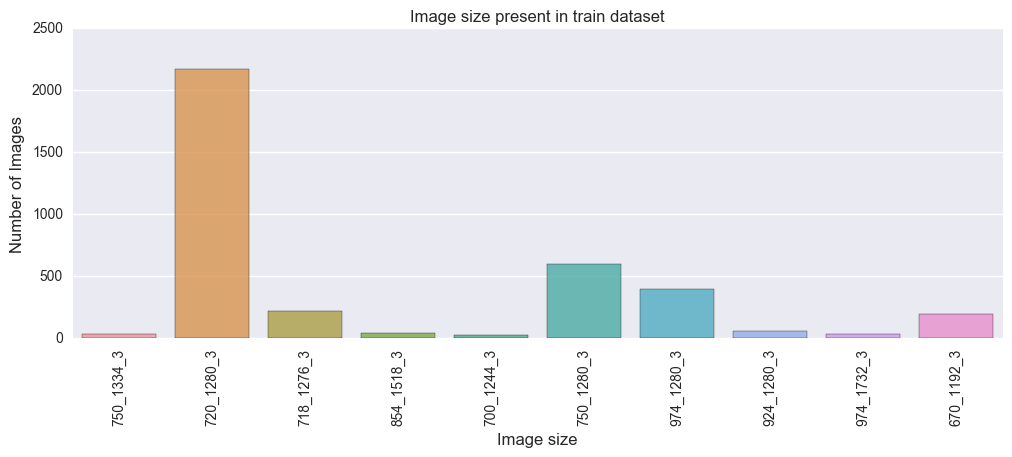

In [7]:
train_path = DATA_HOME_DIR + '/train/'
different_file_sizes = {}

for sub_folder in sub_folders:
    file_names = check_output(["ls", train_path+sub_folder]).decode("utf8").strip().split('\n')
    for file_name in file_names:
        im_array = imread(train_path+sub_folder+"/"+file_name)
        size = "_".join(map(str,list(im_array.shape)))
        different_file_sizes[size] = different_file_sizes.get(size,0) + 1

plt.figure(figsize=(12,4))
sns.barplot(list(different_file_sizes.keys()), list(different_file_sizes.values()), alpha=0.8)
plt.xlabel('Image size', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title("Image size present in train dataset")
plt.xticks(rotation='vertical')
plt.show()

# Plan

1. Create Validation and Sample sets
2. Rearrange image files into their respective directories
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## 1. Create validation and sample sets

In [9]:
%pwd

'/Users/hoangnguyen/Documents/study/kaggle/fish'

In [11]:
%cd data
%mkdir valid

/Users/hoangnguyen/Documents/study/kaggle/fish/data


In [13]:
%cd train
%pwd

/Users/hoangnguyen/Documents/study/kaggle/fish/data/train


'/Users/hoangnguyen/Documents/study/kaggle/fish/data/train'

In [14]:
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [15]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [16]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [17]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/Users/hoangnguyen/Documents/study/kaggle/fish/data/valid
/Users/hoangnguyen/Documents/study/kaggle/fish/data


In [18]:
%mkdir results
%mkdir sample/results
%cd ..

/Users/hoangnguyen/Documents/study/kaggle


## Load batch

In [7]:
??get_batches

In [8]:
batch_size=4

In [9]:
batches = get_batches(DATA_HOME_DIR+'train', batch_size=batch_size)
val_batches = get_batches(DATA_HOME_DIR+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(DATA_HOME_DIR)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [10]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Basic VGG

We start with our usual VGG approach. We will be using VGG with batch normalization. We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb). VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of vgg_ft (our fine tuning function) with batch norm called vgg_ft_bn in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [11]:
sys.path.insert(1, LESSON_HOME_DIR + '/utils/')
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8) # 8 = out_dim

In [12]:
trn = get_data(DATA_HOME_DIR+'train')
val = get_data(DATA_HOME_DIR+'valid')

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [13]:
test = get_data(DATA_HOME_DIR+'test')

Found 1000 images belonging to 1 classes.


Save array into file: train, validation, test

In [14]:
save_array(DATA_HOME_DIR+'results/trn.dat', trn)
save_array(DATA_HOME_DIR+'results/val.dat', val)

In [15]:
save_array(DATA_HOME_DIR+'results/test.dat', test)

Load array from file: train, validation, test

In [17]:
trn = load_array(DATA_HOME_DIR+'results/trn.dat')
val = load_array(DATA_HOME_DIR+'results/val.dat')

In [18]:
test = load_array(DATA_HOME_DIR+'results/test.dat')

Image augmentation

In [19]:
gen = image.ImageDataGenerator()

In [20]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

Fit model

In [21]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
1124/3277 [=========>....................] - ETA: 1290s - loss: 4.2290 - acc: 0.3781

KeyboardInterrupt: 

Save model

In [22]:
model.save_weights(path+'results/ft1.h5')

NameError: name 'path' is not defined